In [423]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# np.random.seed(1)
# random.seed(0)

In [424]:
def graph_1():
    graph = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
    graph1 = [(graph[i][0] + 4, graph[i][1] + 4) for i in range(len(graph))]
    graph2 = [(graph1[i][0] + 4, graph1[i][1] + 4) for i in range(len(graph1))]
    graph += graph1 + graph2
    graph += [(4, 8), (8, 12), (4, 12), (3, 9), (11, 7), (5, 2)]
    return lists_to_matr(graph, 12)


def graph_2():
    return lists_to_matr([(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 1)], 9)

def graph_3(N):
    return lists_to_matr([(1, i) for i in range(2, N+1)], N)

def lists_to_matr(edges, n):
    adj = np.zeros((n, n))
    for edge in edges:
        i = edge[0] - 1
        j = edge[1] - 1
        adj[i][j] = 1.
        adj[j][i] = 1
    return adj

def generate_random_graph(V, E):
    possible_edges = [(i, j) for i in range(V) for j in range(i + 1, V)]
    random_edges = random.sample(possible_edges, E)
    graph = np.zeros((V, V))
    for edge in random_edges:
        u, v = edge
        graph[u][v] = 1
        graph[v][u] = 1

    return graph

In [425]:
def graph_visualize_2d(embs, graph):
    d = len(embs[0])
    for i in range(len(graph)):
        for j in range(i + 1, len(graph)):
            if graph[i][j] == 1:
                xs = [embs[i][0], embs[j][0]]
                ys = [0,0]
                if d!=1:
                    ys = [embs[i][1], embs[j][1]]
                plt.text(xs[1], ys[1], str(j + 1), fontsize=7)
                plt.text(xs[0], ys[0], str(i + 1), fontsize=7)
                plt.plot(xs, ys, marker='o')
    plt.show()

In [426]:
class Layer:
    def forward(self, x):
        raise Exception("Not implement forward method")

    def backward(self, x):
        raise Exception("Not implement forward method")

In [427]:
class NormalizationLayer(Layer):
    def __init__(self, c=1):
        self.forw_x = None
        self.idxs = None
        self.c = c

    def forward(self, x):
        self.forw_x = x
        self.idxs = np.unravel_index(np.argmax(x), x.shape)
        return (self.c / x[self.idxs]) * x

    def backward(self, x):
        x *= self.c
        mx = self.forw_x[self.idxs]
        res = x / mx
        res[self.idxs]-= np.sum(x * self.forw_x) / mx / mx
        return res

In [428]:
class DistanceLayer(Layer):
    def __init__(self):
        self.d = None
        self.forw_x = None
        self.n = None
        self.distances = None

    def forward(self, x):
        self.forw_x = x
        self.d = len(x[0])
        self.n = len(x)
        self.distances = np.zeros((self.n, self.n))
        for i in range(self.n):
            for j in range(i + 1, self.n):
                dist = self.evc2(x[i], x[j])
                self.distances[i][j] = dist
                self.distances[j][i] = dist
        return self.distances
    def backward(self, x):
        res = np.zeros((self.n, self.d))
        for i in range(self.n):
            for j in range(i+1, self.n):
                res[i] += self.evc2_deriv(self.forw_x[j], self.forw_x[i]) * x[i][j] # dDij/dvi
                res[j] -= res[i]
        return res

    @staticmethod
    def evc2_deriv(y, x): # derivative of distance by x
        return 2 * (x - y)
    @staticmethod
    def evc2(x, y):
        return np.sum((x-y)**2)

In [429]:
class DistanceLossLayer(Layer):
    def __init__(self, graph):
        self.backward_losses = None
        self.n = None
        self.distances = None
        self.graph = graph
    def forward(self, x):
        self.distances = x
        self.n = len(x)
        self.backward_losses = np.empty(x.shape)
        loss = 0
        for i in range(self.n):
            for j in range(i+1, self.n):
                c = graph[i][j]
                loss += (1 - c) * self.pushing_func(x[i][j]) + c * self.pulling_func(x[i][j])
                self.backward_losses[i][j] = (1 - c) * self.pushing_func_deriv(x[i][j]) + c * self.pulling_func_deriv(x[i][j])
        return loss

    def backward(self, p=1):
        return self.backward_losses * p

    @staticmethod
    def pushing_func(x):
        if x >= 1:
            return 0
        return 2 - 2 * x

    @staticmethod
    def pushing_func_deriv(x):
        return DistanceLossLayer.sign(x-1) - 1

    @staticmethod
    def pulling_func(x):
        if x<=1:
            return 0
        return 0.5 * x - 0.5

    @staticmethod
    def pulling_func_deriv(x):
        return 1/4 * (1 + DistanceLossLayer.sign(x - 1))

    @staticmethod
    def sign(x):
        if x < 0:
            return -1
        if x > 0:
            return 1
        return 0

In [430]:
class EmbeddingLayer(Layer):
    def __init__(self, n, dim, embs = None):
        self.embeddings = embs
        if embs is None:
            self.embeddings = np.random.rand(n, dim)
        self.grads = np.zeros(self.embeddings.shape)

    def forward(self, x=-1):
        return self.embeddings

    def backward(self, x):
        self.grads += x


In [431]:
class DistanceEmbeddingModel:
    def __init__(self, graph, dim=None, embs=None):
        self.n = len(graph)
        self.graph = graph
        if dim is None:
            dim = round(2.7 * math.log(self.n))
        self.dim = dim
        c = self.n ** ( 1 / dim)
        self.embs = embs
        if embs is None:
            self.embs = self.precalc_embs(-c, c, (self.n, self.dim))
        self.layers = [EmbeddingLayer(self.n, self.dim, self.embs), DistanceLayer(), DistanceLossLayer(graph)]
    def forward(self):
        x = -1
        for layer in self.layers:
            x = layer.forward(x)
        return x
    def backward(self):
        x = 1
        for layer in self.layers[::-1]:
            x = layer.backward(x)
    def precalc_embs(self, l, r, shape):
        embs = np.empty(shape)
        visited = [False] * self.n
        for i in range(self.n):
            if visited[i]:
                continue
            visited[i] = True
            embs[i] = np.random.uniform(l, r, shape[1])
            q = [i]
            while len(q) > 0:
                cur = q[0]
                for j in range(self.n):
                    if self.graph[cur][j] == 1 and not visited[j]:
                        a = np.random.uniform(-1, 1, (shape[1]))
                        a /= np.sum(a ** 2)
                        embs[j] = embs[cur] + a * random.random()
                        visited[j] = True
                        q.append(j)
                del q[0]
        return embs

In [432]:
class GradientDecentOptimizer:
    def __init__(self, params, param_grad, scheduler):
        self.params = params
        self.param_grad = param_grad
        self.scheduler = scheduler
        self.points = []
    def add_point(self, params, loss):
        self.points.append([params, loss])

    def add_loss(self, loss):
        self.scheduler.add_loss(loss)

    def step(self):
        self.params -= self.scheduler.next() * self.param_grad

    def zero_grad(self):
        self.param_grad.fill(0.)

In [433]:
class LRScheduler:
    def __init__(self, lr):
        self.lr = lr
        self.freeze = 90
        self.freeze_eps = 30
        self.cur_fr = 0
        self.losses = []
        self.eps = 1e-4
        self.eq_eps = 1e-12
        self.k = 25
        self.desc_lr = 0.85
        self.asc_eps = 2
        self.ideal = 1e-18

    def next(self):
        mean_k_last = sum(self.losses[max(len(self.losses)-self.k, 0):]) / self.k
        if self.losses[-1] <= self.ideal:
            return 1.
        if self.cur_fr <= -self.freeze_eps:
            self.eps *= self.asc_eps
        if self.cur_fr <= 0:
            cur_eps = abs(mean_k_last - self.losses[-1])
            if  cur_eps <= self.eps:
                self.lr *= self.desc_lr
                self.cur_fr = self.freeze
                self.eps = cur_eps

        if len(self.losses) > 1 and abs(self.losses[-1] - self.losses[-2]) <= self.eq_eps: # Algorith fall into local minimum
            self.lr *= 1 / self.desc_lr

        self.cur_fr -= 1
        return self.lr

    def add_loss(self, loss):
        self.losses.append(loss)


In [434]:
def training(model, optimizer, epoch):
    for i in range(epoch):
        loss = model.forward()
        print(loss)
        optimizer.add_loss(loss)
        model.backward()
        optimizer.step()
        optimizer.zero_grad()

        if loss <= 1e-19:
            break

In [435]:
def graph_correctness_checking(graph, embs, distance_fn):
    for i in range(len(graph)):
        for j in range(i + 1, len(graph)):
            x = distance_fn(embs[i], embs[j])
            if x > 1 and graph[i][j] == 1:
                print(f"Vertices {i} and {j} should be connected! But distances is equal to {x}")
            if x <= 1 and graph[i][j] == 0:
                print(f"Vertices {i} and {j} should be disconnected! But distances is equal to {x}")

In [436]:
# V = 20
# E_max = V * (V - 1) // 2
# E = random.randint(E_max // 2, E_max)
# graph = generate_random_graph(V, E)

In [437]:
graph = graph_1()
D = 2
lr = 0.1
epoch = 6000

In [438]:
model = DistanceEmbeddingModel(graph, D)
print(f"{model.dim}-dimensional embeddings using")

2-dimensional embeddings using


20.828593694056575
19.849545725316695
11.976986377316578
11.750246918370587
9.860266627695045
8.877751174033161
12.051657578695295
9.64861068586192
5.996228988374282
2.637306210846303
3.5065029698210837
2.1633218317570084
1.2803277515678038
0.5970313296830074
1.440031091793092
2.2061506026249518
1.285595535157104
1.0568747016809545
1.9998156585621691
1.20308817369694
1.1796655189232572
1.1410871370279065
1.5681864384645061
0.976605178660692
1.2107040547728085
0.9560984698155428
2.069929313935571
3.2629497052606657
0.8024599815759379
0.2617234330900492
1.3648019415498596
2.6200261339827216
1.7260540257808112
0.5967259951770343
0.7375116651218255
0.8221550628372335
0.9343513633612064
1.301079026521002
1.035259640877543
0.7014336556469825
3.064990820268454
1.197587250006135
0.6018887560661362
0.6667162911496795
0.40113908002211107
0.5116894750683902
1.922381682015588
1.523039282298873
0.4640252590527447
0.29533957514511067
0.38960853060744816
0.4810317469241885
1.8266138766910047
1.009172

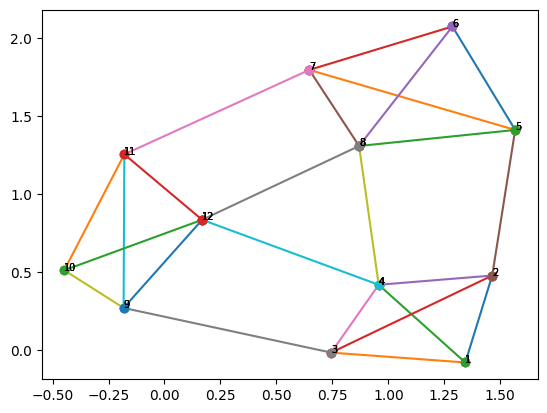

In [439]:
lr_sch = LRScheduler(lr)
optimizer = GradientDecentOptimizer(model.layers[0].embeddings, model.layers[0].grads, lr_sch)

training(model, optimizer, epoch)

embs = model.layers[0].embeddings
graph_visualize_2d(embs, graph)
graph_correctness_checking(graph, embs, model.layers[1].evc2)